In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
import calendar

In [23]:
customers_info = pd.read_csv('olist_customers_dataset.csv')

items_info = pd.read_csv('olist_order_items_dataset.csv', parse_dates=['shipping_limit_date'])

orders_info = pd.read_csv('olist_orders_dataset.csv', parse_dates=['order_estimated_delivery_date',\
                                                         'order_delivered_customer_date',\
                                                         'order_delivered_carrier_date', \
                                                         'order_approved_at', \
                                                         'order_purchase_timestamp'])

In [24]:
# checking data types, the number of missing values, and the dimensions of the dataframe
customers_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [25]:
items_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


In [26]:
orders_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


# Counting Users Who Made a Purchase Only Once

In [27]:
# Joining the customers_info and orders_info dataframes on the customer_id column, as a unique user identifier 
# customer_unique_id is required to determine the number of users
customers_orders = customers_info.merge(orders_info, on = 'customer_id')

In [28]:
# What is not considered a purchase completion:
# Case 1 order_status in ('invoiced', 'unavailable', 'canceled')
# Case 2 order_approved_at.isna() & order_status != 'delivered' 

# Otherwise, purchase completion is considered the inversion of the first and second cases and successful purchases 
# are recorded in a new dataframe named purchase

purchase = customers_orders.query("(order_status not in ('invoiced', 'unavailable', 'canceled'))\
                                    and (not (order_approved_at.isna() & order_status != 'delivered'))")

In [29]:
# Counting the number of orders by user
users_order_count = purchase.groupby('customer_unique_id', as_index = False)\
                            .agg({'order_id':'count'})\
                            .rename(columns = {'order_id':'order_quantity'})

In [30]:
users_with_orders = users_order_count.shape[0]
users_with_one_order = users_order_count.query('order_quantity == 1').shape[0]

percentage_one_order = round((users_with_one_order/users_with_orders * 100), 2)
percentage_several_orders = round((100 - percentage_one_order), 2)

print(f'''{users_with_one_order} users made only one purchase, which constitutes {percentage_one_order} of all 
users who made purchases. Thus, only {percentage_several_orders} of users made more than one purchase''') 

91816 users made only one purchase, which constitutes 96.97 of all 
users who made purchases. Thus, only 3.03 of users made more than one purchase


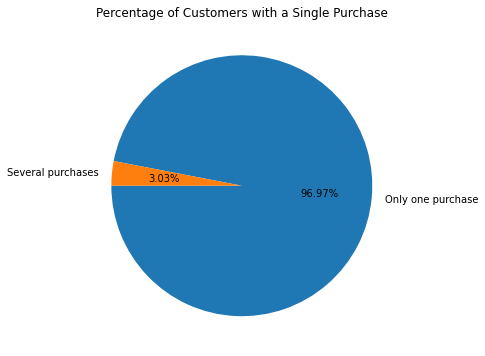

In [31]:
plt.figure(figsize=(6, 6))
plt.pie([percentage_one_order, percentage_several_orders], labels=["Only one purchase", "Several purchases"],\
        autopct="%.2f%%", startangle=180)
plt.title('Percentage of Customers with a Single Purchase')
plt.show()

# Average Monthly Undelivered Orders Due to Various Reasons

In [32]:
# Adding a column with the delivery month number
purchase['month_of_est_delivery'] = purchase['order_estimated_delivery_date'].dt.month

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [33]:
# Counting undelivered orders based on the reason
undelivered_orders_count = purchase.query("order_status != 'delivered'")\
                                    .groupby(['month_of_est_delivery','order_status'], as_index = False)\
                                    .agg({'order_id': 'count'})\
                                    .pivot(index='month_of_est_delivery', columns='order_status', values='order_id')\
                                    .reset_index()\
                                    .fillna(0)
undelivered_orders_count.head()

order_status,month_of_est_delivery,approved,processing,shipped
0,1,0.0,28.0,51.0
1,2,0.0,35.0,64.0
2,3,1.0,44.0,124.0
3,4,0.0,33.0,161.0
4,5,1.0,18.0,172.0


In [34]:
# Calculating the average quantity of undelivered orders per category
undelivered_orders_mean = undelivered_orders_count[['approved', 'processing', 'shipped']]\
                            .mean()\
                            .to_frame()\
                            .reset_index()\
                            .rename(columns = {0:'avg_undelivered_per_month'})\
                            .sort_values('avg_undelivered_per_month', ascending = False)\
                            .round(2)
undelivered_orders_mean

,order_status,avg_undelivered_per_month
2,shipped,92.25
1,processing,25.08
0,approved,0.17


Text(0.5, 1.0, 'Average Undelivered Orders Count per Month by Order Status')

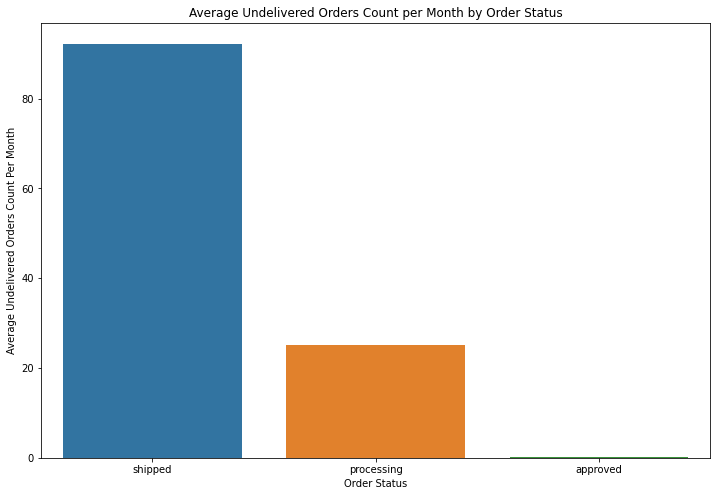

In [35]:
plt.figure(figsize=(12, 8))
sns.barplot(x='order_status', y='avg_undelivered_per_month', data=undelivered_orders_mean)
plt.xlabel('Order Status')
plt.ylabel('Average Undelivered Orders Count Per Month')
plt.title('Average Undelivered Orders Count per Month by Order Status')

# Identifying the Most Purchased Day of the Week for Each Product

In [36]:
items_in_orders = items_info.merge(orders_info, how = 'left', on = 'order_id')

In [37]:
# Adding a column with the day of the week number:
dow = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
items_in_orders['day_of_week_number'] = items_in_orders['order_purchase_timestamp'].dt.dayofweek
items_in_orders['day_of_week'] = items_in_orders['day_of_week_number'].map(dow)

In [38]:
# What is not considered a purchase completion:
# Case 1 order_status in ('invoiced', 'unavailable', 'canceled')
# Case 2 order_approved_at.isna() & order_status != 'delivered' 

# Otherwise, purchase completion is considered the inversion of the first and second cases and successful purchases 
# are recorded in a new dataframe named purchase

sold_items = items_in_orders.query("(order_status not in ('invoiced', 'unavailable', 'canceled'))\
                                    and (not (order_approved_at.isna() & order_status != 'delivered'))")

In [39]:
print(f'Sold {sold_items.product_id.nunique()} unique items.')

Sold 32616 unique items.


In [40]:
# Counting the number of sold items for each product per day of the week
purchases_per_dow = sold_items.groupby(['product_id', 'day_of_week', 'day_of_week_number'], as_index = False)\
                                .agg({'order_item_id':'count'})\
                                .rename(columns = {'order_item_id':'item_sold_quantity'})

In [41]:
# Obtaining the indexes with the maximum quantity of sold units for each unique product
indexes_most_sold = purchases_per_dow.groupby('product_id').item_sold_quantity.idxmax()

In [42]:
# Filtering by max indexes, dropping unnecessary rows, sorting by popularity in descending order
most_purchased_dow_per_product = purchases_per_dow.loc[indexes_most_sold]\
                                .sort_values('item_sold_quantity', ascending = False)

most_purchased_dow_per_product.head()

,product_id,day_of_week,day_of_week_number,item_sold_quantity
15766,422879e10f46682990de24d770e7f83d,Wed,2,93
36178,99a4788cb24856965c36a24e339b6058,Mon,0,92
40679,aca2eb7d00ea1a7b8ebd4e68314663af,Thu,3,89
19944,53b36df67ebb7c41585e8d54d6772e08,Tue,1,76
12892,368c6c730842d78016ad823897a372db,Fri,4,67


# Determining the most popular day of the week overall

In [43]:
most_popular_dow = most_purchased_dow_per_product.groupby(['day_of_week','day_of_week_number'], as_index = False)\
                                                .agg({'item_sold_quantity':'sum'})\
                                                .sort_values('day_of_week_number')

most_popular_dow.set_index('day_of_week_number', inplace=True)
most_popular_dow

,day_of_week,item_sold_quantity
day_of_week_number,,
0,Mon,10973
1,Tue,8335
2,Wed,7418
3,Thu,7711
4,Fri,9373
5,Sat,5155
6,Sun,5627


Text(0.5, 1.0, 'Popularity of Day of Sold Items')

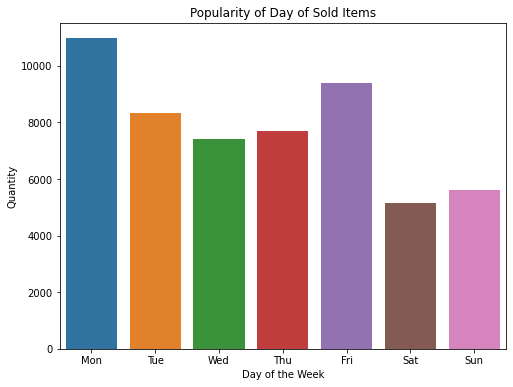

In [44]:
plt.figure(figsize=(8, 6))
sns.barplot(x='day_of_week', y='item_sold_quantity', data=most_popular_dow)
plt.xlabel('Day of the Week')
plt.ylabel('Quantity')
plt.title('Popularity of Day of Sold Items')

# Average Weekly Purchases per Unique User (in a specific month)

In [45]:
# information about the year and month of order creation
purchase['purchase_month'] = purchase['order_purchase_timestamp'].dt.month
purchase['purchase_year'] = purchase['order_purchase_timestamp'].dt.year

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
# Creating a column to count the number of weeks in a specific year and month
purchase['weeks_in_month'] = purchase.apply(lambda x: calendar.monthrange(x['purchase_year'],\
                                                                        x['purchase_month'])[1]/7, axis=1)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [47]:
# Calculating the total number of purchases by a user per month
weekly_purchase = purchase.groupby(['customer_unique_id','purchase_month','purchase_year','weeks_in_month'], as_index = False)\
                            .agg({'order_id':'count'})\
                            .rename(columns = {'order_id':'order_quantity'})\
                            .sort_values('order_quantity', ascending = False)
weekly_purchase.head()

,customer_unique_id,purchase_month,purchase_year,weeks_in_month,order_quantity
7214,12f5d6e1cbf93dafd9dcc19095df0b3d,1,2017,4.428571,6
61254,a239b8e2fbce33780f1f1912e2ee5275,2,2017,4.000000,4
49855,83e7958a94bd7f74a9414d8782f87628,1,2017,4.428571,4
68342,b4e4f24de1e8725b74e4a1f4975116ed,2,2018,4.000000,4
14263,25a560b9a6006157838aab1bdbd68624,4,2017,4.285714,4


In [48]:
# Dividing the total number of purchases in a month by the number of weeks in that month to obtain 
# the average number of purchases per week (in a specific month)
weekly_purchase['avg_purchase_per_week'] = round(weekly_purchase.order_quantity / weekly_purchase.weeks_in_month,2)

In [49]:
# Removing unnecessary columns 
weekly_avg_purchase = weekly_purchase.drop(['weeks_in_month','order_quantity'], axis = 1)

In [50]:
# For example, let's find the user who made the most purchases on average per week in January 2017

In [51]:
example = weekly_avg_purchase.query("purchase_month == 1 & purchase_year == 2017")\
                            .sort_values('avg_purchase_per_week', ascending = False).head()
example

,customer_unique_id,purchase_month,purchase_year,avg_purchase_per_week
7214,12f5d6e1cbf93dafd9dcc19095df0b3d,1,2017,1.35
49855,83e7958a94bd7f74a9414d8782f87628,1,2017,0.90
37151,6222ef69df52b4ed71be551725551cc0,1,2017,0.68
43332,728e4a7d0db4845270091ded0923c71f,1,2017,0.68
17521,2e43e031f10de28e557c35ef668f9396,1,2017,0.68


In [52]:
print(f'''In January 2017 User {example['customer_unique_id'].iloc[0]} 
        made the most purchases on average per week''')

In January 2017 User 12f5d6e1cbf93dafd9dcc19095df0b3d 
        made the most purchases on average per week


# Average Weekly Purchase Quantity for All Users Overall, by Month

In [53]:
all_users_avg_purchase_quantity = weekly_avg_purchase.groupby('purchase_month')\
                                                .agg({'avg_purchase_per_week':'sum'})

all_users_avg_purchase_quantity.index = list(calendar.month_name)[1:]

all_users_avg_purchase_quantity = all_users_avg_purchase_quantity.reset_index()\
                                    .rename(columns = {'index':'purchase_month'})
all_users_avg_purchase_quantity

,purchase_month,avg_purchase_per_week
0,January,1826.55
1,February,2081.25
2,March,2243.29
3,April,2132.46
4,May,2398.34
5,June,2148.25
6,July,2335.25
7,August,2448.38
8,September,969.66
9,October,1104.72


Text(0.5, 1.0, 'Average Weekly Purchase Quantity for All Users Overall, by Month')

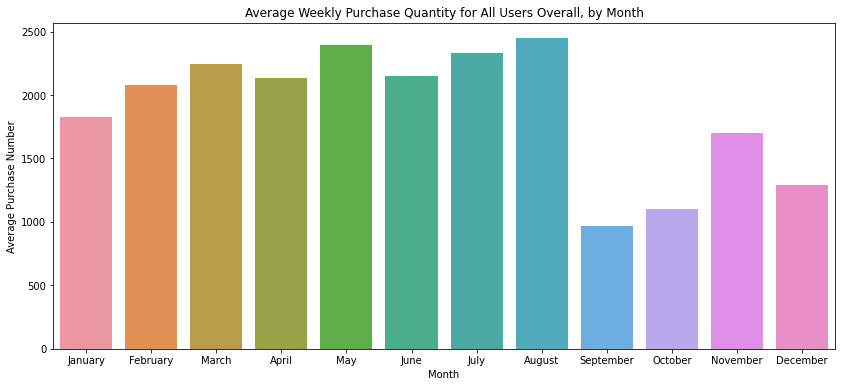

In [54]:
plt.figure(figsize=(14, 6))
sns.barplot(x='purchase_month', y='avg_purchase_per_week', data=all_users_avg_purchase_quantity)
plt.xlabel('Month')
plt.ylabel('Average Purchase Number')
plt.title('Average Weekly Purchase Quantity for All Users Overall, by Month')

# Retention. Cohort Analysis. 

In [55]:
# Determining the first order date for each customer
first_order = purchase.groupby('customer_unique_id', as_index = False)\
                        .agg({'order_purchase_timestamp':'min'})\
                        .rename(columns = {'order_purchase_timestamp':'first_order_date'})
# Labeling cohorts by months
first_order['cohort'] = first_order['first_order_date'].dt.to_period('M')

In [56]:
first_order.head()

,customer_unique_id,first_order_date,cohort
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,2018-05
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,2018-05
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,2017-03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,2017-10
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,2017-11


In [57]:
# Adding information about the first order date and cohorts to the purchase df
purchase = purchase.merge(first_order, how = 'left', on = 'customer_unique_id')

In [58]:
# Calculating the number of days from the first order to next ones

purchase['days_past_since_first_order'] = (purchase.order_purchase_timestamp - purchase.first_order_date).dt.days
avg_days_to_new_order = purchase['days_past_since_first_order'].mean().round(2)
avg_days_to_new_order

2.86

In [59]:
# Creating a column with information about timestamps 1 and 2 months after the first order
purchase['second_month'] = purchase['first_order_date'] + pd.DateOffset(months=1)
purchase['third_month'] = purchase['first_order_date'] + pd.DateOffset(months=2)

In [60]:
# Counting the number of orders in the first month for each cohort
cohorts_first_month = purchase.query("order_purchase_timestamp == first_order_date")\
                                .groupby('cohort', as_index = False)\
                                .agg({'customer_unique_id':'count'})\
                                .rename(columns = {'customer_unique_id':'1st_month_active_users_count'})

In [61]:
# Counting the number of orders in the second month for each cohort
cohorts_second_month = purchase.query("first_order_date < order_purchase_timestamp <= second_month")\
                                .groupby('cohort', as_index = False)\
                                .agg({'customer_unique_id':'count'})\
                                .rename(columns = {'customer_unique_id':'2nd_month_active_users_count'})

In [62]:
# Counting the number of orders in the third month for each cohort
cohorts_third_month = purchase.query("second_month < order_purchase_timestamp <= third_month")\
                                .groupby('cohort', as_index = False)\
                                .agg({'customer_unique_id':'count'})\
                                .rename(columns = {'customer_unique_id':'3rd_month_active_users_count'})

In [63]:
# Combining dataframes with information on the number of users in the 1st, 2nd, and 3rd months for each cohort
all_cohorts_df = cohorts_first_month.merge(cohorts_second_month, how = 'left', on = 'cohort')\
                                            .merge(cohorts_third_month, how = 'left', on = 'cohort')\
                                            .fillna(0)

all_cohorts_df

,cohort,1st_month_active_users_count,2nd_month_active_users_count,3rd_month_active_users_count
0,2016-09,2,0.0,0.0
1,2016-10,272,3.0,0.0
2,2016-12,1,1.0,0.0
3,2017-01,746,30.0,3.0
4,2017-02,1682,25.0,3.0
5,2017-03,2574,44.0,7.0
6,2017-04,2317,35.0,10.0
7,2017-05,3542,64.0,16.0
8,2017-06,3103,52.0,13.0
9,2017-07,3832,70.0,14.0


In [64]:
month_columns = ['1st_month_active_users_count','2nd_month_active_users_count','3rd_month_active_users_count']
month_columns_percentage = ['1st_month_active_users_%','2nd_month_active_users_%','3rd_month_active_users_%']
dict_columns = dict(zip(month_columns, month_columns_percentage))

retention_rate = all_cohorts_df

retention_rate[month_columns] = retention_rate[month_columns]\
                                .apply(lambda x: (x / retention_rate[month_columns[0]] * 100))\
                                .round(2)
retention_rate = retention_rate.set_index('cohort').rename(columns = dict_columns)

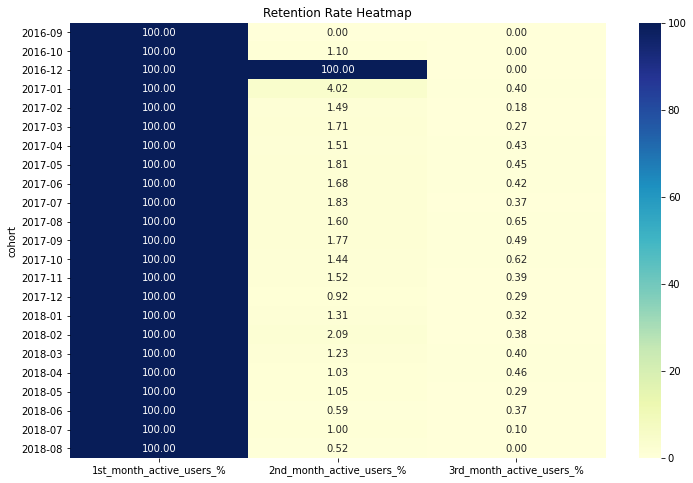

In [65]:
plt.figure(figsize=(12, 8))
sns.heatmap(data = retention_rate, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Retention Rate Heatmap")
plt.show()

In [66]:
# Getting the index with the maximum retention rate for the third month
max_retention_index = retention_rate['3rd_month_active_users_%'].idxmax()

# Maximum retention rate for the third month
max_retention = round(retention_rate.loc[max_retention_index, '3rd_month_active_users_%'], 2) 

In [67]:
print (f'''The cohort with the highest retention rate in the third month is - {max_retention_index},
retention rate = {max_retention}%.''')

The cohort with the highest retention rate in the third month is - 2017-08,
retention rate = 0.65%.


# RFM segmentation

In [68]:
full_df = items_info.merge(purchase, how = 'left', on = 'order_id')

In [69]:
# Number of orders with a specific quantity of items within a single order
full_df.order_item_id.value_counts()

1     98666
2      9803
3      2287
4       965
5       460
6       256
7        58
8        36
9        28
10       25
11       17
12       13
13        8
14        7
15        5
20        3
16        3
17        3
18        3
19        3
21        1
Name: order_item_id, dtype: int64

In [70]:
# Information about the complete period of orders
date_min = full_df['order_purchase_timestamp'].min()
date_max = full_df['order_purchase_timestamp'].max()
print(f'Orders from {date_min} to {date_max}.')

Orders from 2016-09-04 21:15:19 to 2018-09-03 09:06:57.


In [71]:
full_df['full_cost'] = full_df.order_item_id * full_df.price

In [72]:
# Grouping by customer ID and order time, calculating the revenue per user
customers_purchases_by_time = full_df.groupby(['customer_unique_id', 'order_purchase_timestamp'], as_index = False)\
                                    .agg({'full_cost':'sum'})
customers_purchases_by_time

,customer_unique_id,order_purchase_timestamp,full_cost
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,18.90
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,25.99
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,180.00
...,...,...,...
97600,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,2250.00
97601,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,64.89
97602,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,89.90
97603,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,115.00


In [74]:
# Calculating the duration in days since the order was made
customers_purchases_by_time['days_since_order'] = customers_purchases_by_time['order_purchase_timestamp']\
                                                .apply(lambda x: (date_max - x).days)

In [78]:
# DataFrame with information on Frequency, i.e., how many orders per unique user were made
Frequency = customers_purchases_by_time.groupby('customer_unique_id', as_index = False)\
                                        .agg({'order_purchase_timestamp': 'count'})\
                                        .rename(columns={'order_purchase_timestamp': 'Frequency'})\
                                        .sort_values('Frequency', ascending = False)

In [79]:
# DataFrame with information on Recency, i.e., how many days have passed since the last order for each user
Recency = customers_purchases_by_time.groupby('customer_unique_id', as_index = False)\
                                    .agg({'days_since_order':'min'})\
                                    .rename(columns={'days_since_order': 'Recency'})

In [80]:
# DataFrame with information on Monetary, i.e., the total amount spent by each user
Monetary = customers_purchases_by_time.groupby('customer_unique_id', as_index = False)\
                                    .agg({'full_cost':'sum'})\
                                    .rename(columns={'full_cost': 'Monetary'})

In [81]:
# Merging the Recency, Frequency, and Monetary dataframes into a unified RFM dataframe
RFM = Recency.merge(Frequency, on = 'customer_unique_id').merge(Monetary, on = 'customer_unique_id').fillna(0)

In [84]:
# Calculating quantile values for ranking in 'Recency' and 'Monetary
quintiles = RFM[['Recency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'Recency': {0.2: 97.0, 0.4: 181.0, 0.6: 272.0, 0.8: 387.0},
 'Monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 115.0, 0.8: 195.9}}

In [85]:
# Verifying Frequency since the value is 1 at all specified quantiles
Frequency.Frequency.value_counts()

1     92064
2      2416
3       161
4        29
5         8
6         4
7         3
16        1
9         1
Name: Frequency, dtype: int64

In [87]:
# Indeed, too many values with only one purchase were obtained (as obtained from the first step, this 
# constitutes 97% of all purchases). Since all parameters are evaluated on a scale from 1 to 5, 5 intervals 
# are needed, which are defined with four quantile values. For the selected quantiles [.2, .4, .6, .8], 
# the Frequency values are distributed uniformly with a value of 1. This is not suitable because there will be 
# no difference in ranks. Therefore, absolute values from Frequency.value_counts [1, 2, 3, 4] will have to be used, 
# where 1 is considered poor, and 4 indicates at least 4 repeat purchases, which is considered good

In [88]:
# Ranking assignment for 'Recency', 'Frequency', 'Monetary'. 

# In the case of Recency, the lower the value, the better, as it indicates that the purchase was made recently
def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1
    
# In the case of Frequency, the higher the value, the better, as it indicates that the person makes frequent 
# repeat purchases
def f_score(x):
    if x <= 1:
        return 1
    elif x <= 2:
        return 2
    elif x <= 3:
        return 3
    elif x <= 4:
        return 4
    else:
        return 5  
# In the case of Monetary, the higher the value, the better, as it indicates that the person spends more 
# money on purchases
def m_score(x):
    if x <= quintiles['Monetary'][.2]:
        return 1
    elif x <= quintiles['Monetary'][.4]:
        return 2
    elif x <= quintiles['Monetary'][.6]:
        return 3
    elif x <= quintiles['Monetary'][.8]:
        return 4
    else:
        return 5    

In [89]:
# Creating columns 'R', 'F', 'M' with the ranks for 'Recency', 'Frequency', 'Monetary'
RFM['R'] = RFM['Recency'].apply(lambda x: r_score(x))
RFM['F'] = RFM['Frequency'].apply(lambda x: f_score(x))
RFM['M'] = RFM['Monetary'].apply(lambda x: m_score(x))

In [90]:
# Concatenation of ranks for the RFM_segment column with RFM segments
RFM['RFM_segment'] = RFM['R'].map(str) + RFM['F'].map(str) + RFM['M'].map(str)

In [91]:
# Creating a dictionary categories, where keys are regular expressions (first two digits of the segment), 
# and values are customer segments in descriptive form based on certain criteria.

# hibernating - poor Recency and Frequency (made a purchase long ago and did not return for a repeat purchase)

# at risk - poor Recency and average Frequency (made a purchase long ago but returned multiple times)

# can not loose - poor Recency and good Frequency (made a purchase long ago but purchased frequently)

# about to sleep - average Recency and poor Frequency (made a purchase not too long ago but did not return for 
# a repeat purchase)

# need attention - average Recency and average Frequency (made a purchase not too long ago and returned multiple 
# times)

# loyal customers - average Recency and good Frequency (made a purchase not too long ago and purchases frequently)

# promising - good Recency and poor Frequency (made a purchase very recently but has not returned yet)

# potential loyalists - good Recency and average Frequency (made a purchase very recently and returned multiple times)

# champions - good Recency and good Frequency (made a purchase very recently and purchases frequently)


categories = {
    r'[1-2]1': 'hibernating',
    r'[1-2][2-3]': 'at risk',
    r'[1-2][4-5]': 'can not loose',
    
    r'31': 'about to sleep',
    r'3[2-3]': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    
    r'[4-5]1': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'5[4-5]': 'champions'
}

RFM['Segment'] = RFM['R'].map(str) + RFM['F'].map(str)
RFM['Segment'] = RFM['Segment'].replace(categories, regex=True)
RFM.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM_segment,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,115,1,129.90,4,1,4,414,new customers
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,18.90,4,1,1,411,new customers
2,0000f46a3911fa3c0805444483337064,541,1,69.00,1,1,2,112,hibernating
3,0000f6ccb0745a6a4b88665a16c9f078,325,1,25.99,2,1,1,211,hibernating
4,0004aac84e0df4da2b147fca70cf8255,292,1,180.00,2,1,4,214,hibernating


In [99]:
# Calculating the number of customers in each segment
segments_counts = RFM.groupby('Segment', as_index = False)\
                    .agg({'customer_unique_id':pd.Series.nunique})\
                    .rename(columns = {'customer_unique_id':'number_of_customers'})\
                    .sort_values('number_of_customers', ascending = False)
segments_counts

,Segment,number_of_customers
4,hibernating,36850
7,new customers,36791
0,about to sleep,18423
8,potential loyalists,1136
1,at risk,888
6,need attention,553
3,champions,20
5,loyal customers,19
2,can not loose,7
